# 006. Data exploration and analysis

Exploring the statistics of the data to be used is an essential part before feeding a statistical model with it. In this short notebook, we want to highlight some of the methods used and how the the data for an examplary region looks like.

enable parent dir package loading

In [1]:
import link_src

In [2]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(processes=True)
import dask
#dask.config.set(scheduler='processes')
from dask.diagnostics import ProgressBar

In [3]:
from python.aux.ml_flood_config import path_to_data
# load dask client
client
# define some vars
data_path = f'{path_to_data}danube/'
print(data_path)

/home/srvx11/lehre/users/a1303583/ipython/ml_flood/data/danube/


In [ ]:
from python.aux.utils import open_data
# load data
era5 = open_data(data_path, kw='era5')
glofas = open_data(data_path, kw='glofas_ra')

Use the **calc_stat_moments** function to get the first, second moment and the coefficient of variation. Via the **dim_aggregator** you can choose the dimension over which the quantities are calculated. A subset of the time period can be set with the **time_constraint** kwarg.

In [5]:
from python.aux.utils import calc_stat_moments
sm = calc_stat_moments(ds=era5, dim_aggregator='time', time_constraint=None)

Note that an additional dimension with a corresponding coordinate **stat_moments** is added, via which the mean, standard deviation, or coefficient of variation can be accessed.

In [6]:
print(sm)

<xarray.Dataset>
Dimensions:       (latitude: 13, level: 3, longitude: 53, stat_moments: 3)
Coordinates:
  * latitude      (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * longitude     (longitude) float32 7.0 7.25 7.5 7.75 ... 19.5 19.75 20.0
  * level         (level) float64 850.0 700.0 500.0
  * stat_moments  (stat_moments) <U4 'mean' 'std' 'vc'
Data variables:
    cp            (stat_moments, latitude, longitude) float32 dask.array<shape=(3, 13, 53), chunksize=(1, 13, 53)>
    tp            (stat_moments, latitude, longitude) float32 dask.array<shape=(3, 13, 53), chunksize=(1, 13, 53)>
    lsp           (stat_moments, latitude, longitude) float32 dask.array<shape=(3, 13, 53), chunksize=(1, 13, 53)>
    z             (stat_moments, level, latitude, longitude) float32 dask.array<shape=(3, 3, 13, 53), chunksize=(1, 3, 13, 53)>
    t             (stat_moments, level, latitude, longitude) float32 dask.array<shape=(3, 3, 13, 53), chunksize=(1, 3, 13, 53)>
    q           

Now we create a **Map** object to quickly be able to glance over the data. Map-Plots are generated with cartopy and containt rivers in blue, as well as major water catchment basins in green.

In [7]:
from python.aux.plot import Map
m = Map(figure_kws=dict(figsize=(15,10)))

Specify the variable and statistical quantity to be plotted and call the Map with the data array as input.

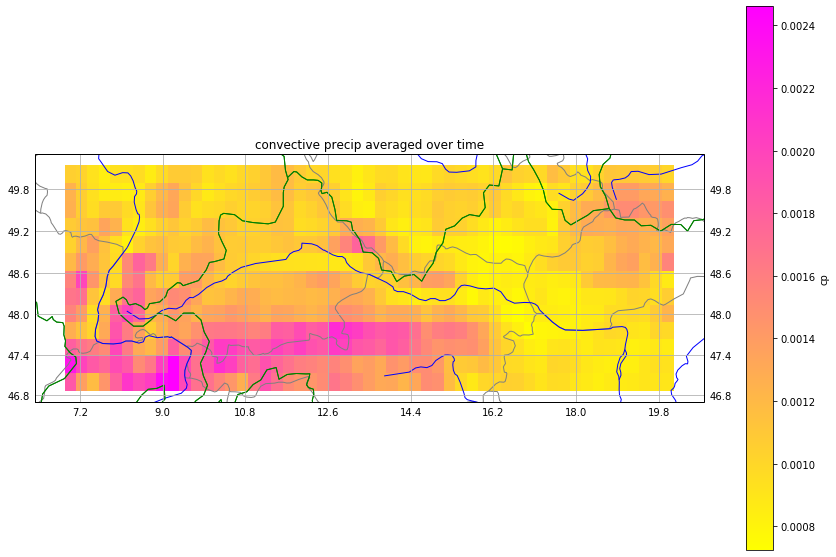

In [8]:
da_mean = sm['cp'].sel(stat_moments='mean').compute()
m.plot(da_mean)
plt.title('convective precip averaged over time')
plt.show()

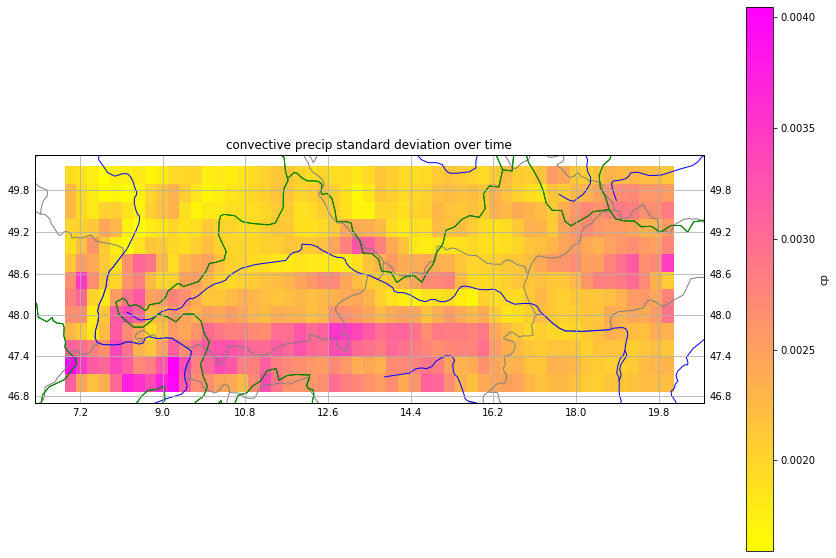

In [9]:
da_mean = sm['cp'].sel(stat_moments='std').compute()
m.plot(da_mean)
plt.title('convective precip standard deviation over time')
plt.show()

In [10]:
da_mean = sm['cp'].sel(stat_moments='vc').compute()

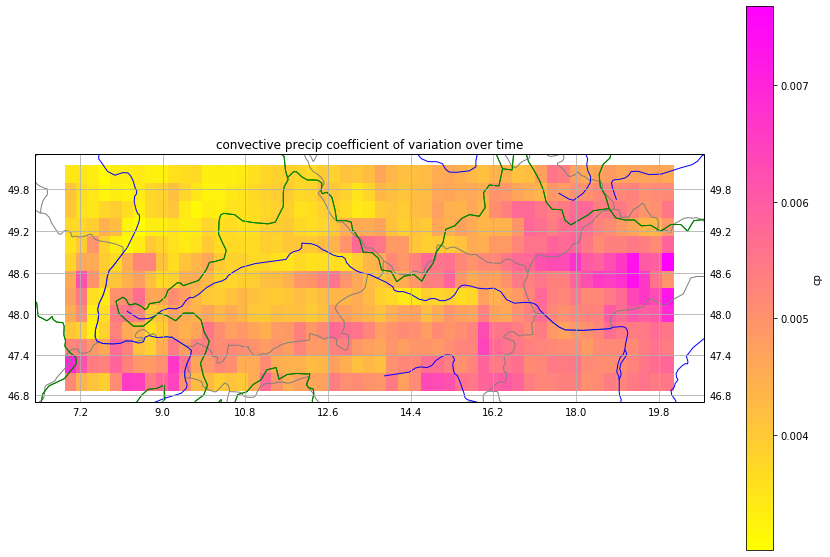

In [11]:
m.plot(da_mean, cbar_kwargs={'fraction': 0.1})
plt.title('convective precip coefficient of variation over time')
plt.show()

What about statistical quantities over time?

In [12]:
sm_time = calc_stat_moments(ds=era5, dim_aggregator='spatial', time_constraint=None)

In [13]:
# resample to yearly values
da_time_mean = sm_time[['cp', 'lsp']].sel(stat_moments='mean').compute().resample(time="y").mean()

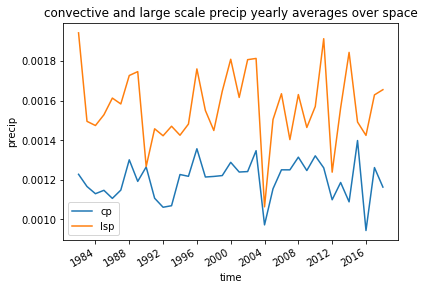

In [14]:
da_time_mean['cp'].plot(label='cp')
da_time_mean['lsp'].plot(label='lsp')
plt.legend()
plt.title('convective and large scale precip yearly averages over space')
plt.ylabel('precip')
plt.show()

Now, lets look at spatial covariances for a specified location. This is done via the **spatial_cov** method in the **utils.py** file. It is built on top of xarray for a fast calculation and takes a dataarray with dimension time, latitude and longitude as input, as well as the latitude and longitude value from the location.

In [15]:
from python.aux.utils import spatial_cov

In [16]:
cp = era5['cp']
lat = 48.5
lon = 15.5
scov = spatial_cov(cp, lat=lat, lon=lon)

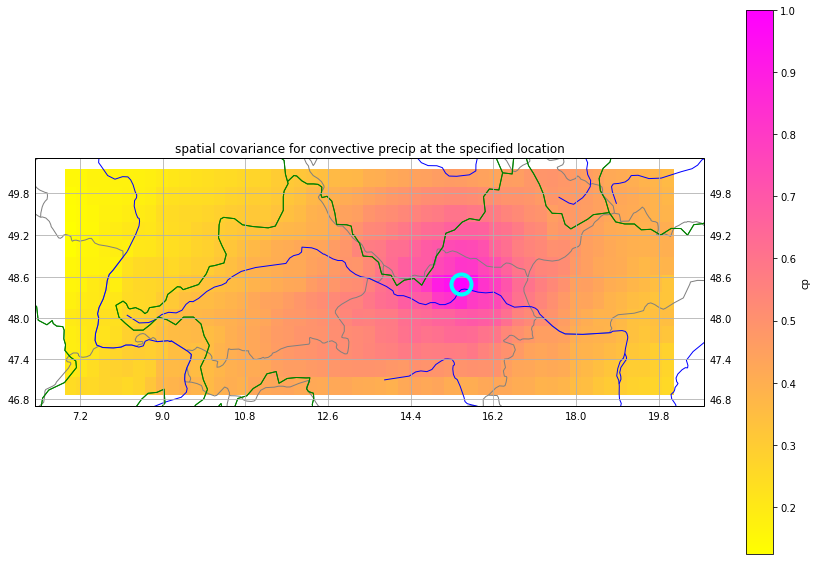

In [17]:
m.plot(scov)
plt.title('spatial covariance for convective precip at the specified location')
m.plot_point(plt.gca(), lat, lon)